<a href="https://colab.research.google.com/github/nigimitama/Qiita/blob/master/sparse_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# どの程度sparseなら疎行列クラスの効果が出るのか？

### 背景
疎（sparse）なデータは疎行列用のクラスで保持したほうがメモリ効率がよくなり、計算効率も上がる。

どの程度sparseであればそのメリットを享受できるのだろうか。

### 方法

- 0.0か1.0の実数の要素からなる100,000行 x 100列の行列を使う。
- 行列にどの程度非ゼロの値が含まれるかを0.1, 0.2, ..., 1.0の割合へと変化させていきながら、XGBoostとLightBGMでの計算時間を計測する。
- 疎行列クラスとしてscipyのcsr_matrixとcsc_matrixを使い、np.arrayと比較する


### 結果

#### LightGBM
- 非ゼロ要素の割合が10%の疎なデータであっても、疎行列クラスのパフォーマンスはnp.arrayと大差ない
- 非ゼロ要素の割合が40%を超えるあたりからはnp.arrayのほうがパフォーマンスが高い


#### XGBoost

- 非ゼロの要素の割合が約85%を下回る時は疎行列クラスを使ったほうが計算時間は短く済む。
- 非ゼロ要素の割合が約85%以上になってくるとnp.arrayのほうが計算時間が短くなる。







In [21]:
!cat /proc/cpuinfo | grep -m1 "model name"

model name	: Intel(R) Xeon(R) CPU @ 2.30GHz


In [22]:
!python3 --version

Python 3.6.9


In [23]:
import numpy
import scipy

print(np.__version__)
print(scipy.__version__)

1.17.4
1.3.3


## 和

In [24]:
import pandas as pd
import timeit
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix

def gen_dataset(nrow=100000, ncol=100, p=0.5):
    x = np.random.binomial(n=1, p=p, size=nrow*ncol)
    X = x.reshape(nrow, ncol).astype(np.float16)
    return X

results = []
for nrow in [100, 1000, 10000]:
    ncol = nrow
    for p in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        print(f"# nrow={nrow}, ncol={ncol}, p={p} "+"-"*50)
        A_np = gen_dataset(nrow=nrow, ncol=ncol, p=p)
        B_np = gen_dataset(nrow=nrow, ncol=ncol, p=p)
        for matrix in ["np", "lil", "csr", "csc"]:
            if matrix == "lil":
                A = lil_matrix(A_np)
                B = lil_matrix(B_np)
            elif matrix == "csr":
                A = csr_matrix(A_np)
                B = csr_matrix(B_np)
            elif matrix == "csc":
                A = csc_matrix(A_np)
                B = csc_matrix(B_np)
            else:
                A = A_np
                B = B_np
            t = timeit.Timer('A + B', globals=globals())
            fit_times = t.repeat(repeat=3, number=1)
            result = {"nrow": nrow, "ncol": ncol, "p": p, "matrix": matrix, 
                            "mean": np.mean(fit_times), "std": np.std(fit_times)}
            results.append(result)
results = pd.DataFrame(results)

# nrow=100, ncol=100, p=0.01 --------------------------------------------------
# nrow=100, ncol=100, p=0.05 --------------------------------------------------
# nrow=100, ncol=100, p=0.1 --------------------------------------------------
# nrow=100, ncol=100, p=0.2 --------------------------------------------------
# nrow=100, ncol=100, p=0.3 --------------------------------------------------
# nrow=100, ncol=100, p=0.4 --------------------------------------------------
# nrow=100, ncol=100, p=0.5 --------------------------------------------------
# nrow=100, ncol=100, p=0.6 --------------------------------------------------
# nrow=100, ncol=100, p=0.7 --------------------------------------------------
# nrow=100, ncol=100, p=0.8 --------------------------------------------------
# nrow=100, ncol=100, p=0.9 --------------------------------------------------
# nrow=100, ncol=100, p=1.0 --------------------------------------------------
# nrow=1000, ncol=1000, p=0.01 -------------------

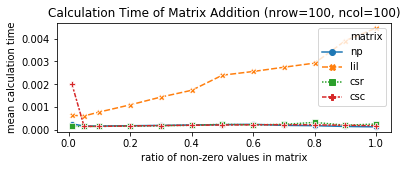

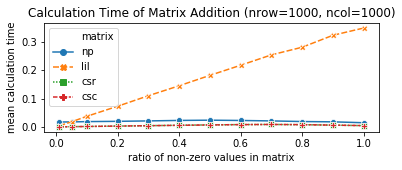

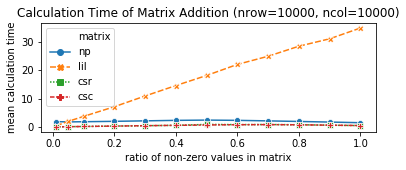

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
for nrow in results.nrow.unique():
        ncol = nrow
        temp = results.query(f"nrow == {nrow} and ncol == {ncol}")
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of Matrix Addition (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

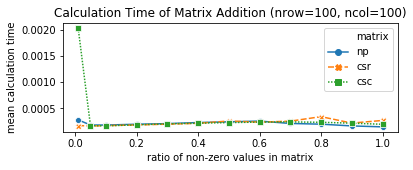

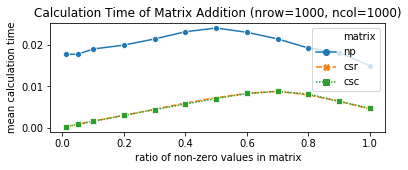

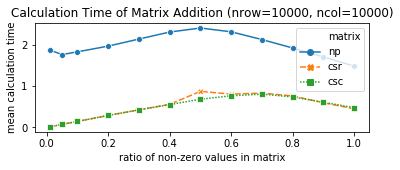

In [26]:
# without lil
for nrow in results.nrow.unique():
        ncol = nrow
        temp = results.query("matrix != 'lil'").query(f"nrow == {nrow} and ncol == {ncol}")
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of Matrix Addition (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

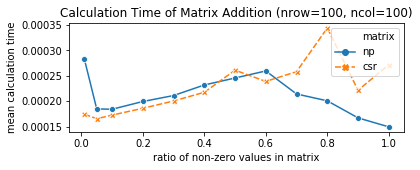

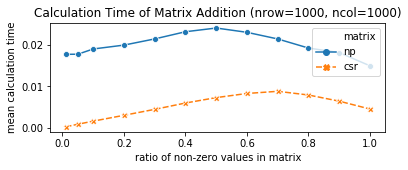

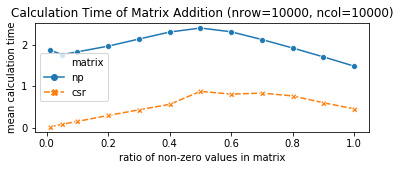

In [27]:
# only np.array, csr
for nrow in results.nrow.unique():
        ncol = nrow
        temp = results.query("matrix != 'lil' and matrix != 'csc'").query(f"nrow == {nrow} and ncol == {ncol}")
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of Matrix Addition (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

## 積

In [28]:
import pandas as pd
import timeit
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix

def gen_dataset(nrow=100000, ncol=100, p=0.5):
    x = np.random.binomial(n=1, p=p, size=nrow*ncol)
    X = x.reshape(nrow, ncol).astype(np.float16)
    return X

results = []
for nrow in [100, 1000]:
    ncol = nrow
    for p in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        print(f"# nrow={nrow}, ncol={ncol}, p={p} "+"-"*50)
        A_np = gen_dataset(nrow=nrow, ncol=ncol, p=p)
        B_np = gen_dataset(nrow=nrow, ncol=ncol, p=p)
        for matrix in ["np", "lil", "csr", "csc"]:
            if matrix == "lil":
                A = lil_matrix(A_np)
                B = lil_matrix(B_np)
            elif matrix == "csr":
                A = csr_matrix(A_np)
                B = csr_matrix(B_np)
            elif matrix == "csc":
                A = csc_matrix(A_np)
                B = csc_matrix(B_np)
            else:
                A = A_np
                B = B_np
            t = timeit.Timer('A.dot(B)', globals=globals())
            fit_times = t.repeat(repeat=10, number=1)
            result = {"nrow": nrow, "ncol": ncol, "p": p, "matrix": matrix, 
                            "mean": np.mean(fit_times), "std": np.std(fit_times)}
            results.append(result)
results = pd.DataFrame(results)

# nrow=100, ncol=100, p=0.01 --------------------------------------------------
# nrow=100, ncol=100, p=0.05 --------------------------------------------------
# nrow=100, ncol=100, p=0.1 --------------------------------------------------
# nrow=100, ncol=100, p=0.2 --------------------------------------------------
# nrow=100, ncol=100, p=0.3 --------------------------------------------------
# nrow=100, ncol=100, p=0.4 --------------------------------------------------
# nrow=100, ncol=100, p=0.5 --------------------------------------------------
# nrow=100, ncol=100, p=0.6 --------------------------------------------------
# nrow=100, ncol=100, p=0.7 --------------------------------------------------
# nrow=100, ncol=100, p=0.8 --------------------------------------------------
# nrow=100, ncol=100, p=0.9 --------------------------------------------------
# nrow=100, ncol=100, p=1.0 --------------------------------------------------
# nrow=1000, ncol=1000, p=0.01 -------------------

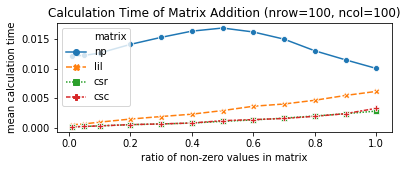

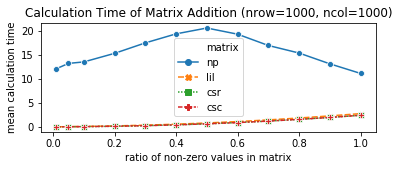

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
for nrow in results.nrow.unique():
        ncol = nrow
        temp = results.query(f"nrow == {nrow} and ncol == {ncol}")
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of Matrix Addition (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

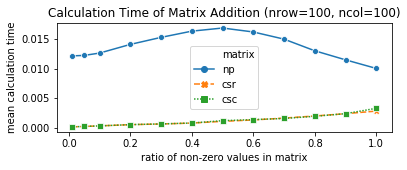

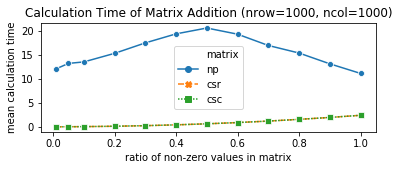

In [30]:
# without lil
for nrow in results.nrow.unique():
        ncol = nrow
        temp = results.query("matrix != 'lil'").query(f"nrow == {nrow} and ncol == {ncol}")
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of Matrix Addition (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

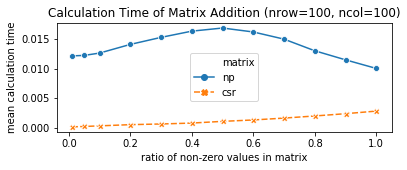

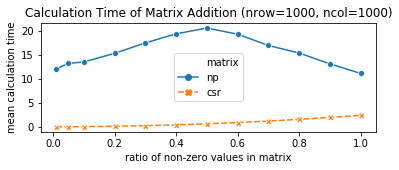

In [31]:
# only np.array, csr
for nrow in results.nrow.unique():
        ncol = nrow
        temp = results.query("matrix != 'lil' and matrix != 'csc'").query(f"nrow == {nrow} and ncol == {ncol}")
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of Matrix Addition (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

## XGBoost / LightGBM

In [0]:
import pandas as pd
import timeit
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix


def gen_dataset(nrow=100000, ncol=100, p=0.5):
    x = np.random.binomial(n=1, p=p, size=nrow*ncol)
    X = x.reshape(nrow, ncol).astype(np.float16)
    y = np.apply_along_axis(_func, 1, X)
    return X, y


def _func(row: np.array):
    return np.sum(row) + np.random.rand()

results = []
for nrow in [100, 1000, 10000, 100000]:
    for ncol in [10, 100]:
        for p in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            print(f"# nrow={nrow}, ncol={ncol}, p={p} "+"-"*50)
            X_np, y = gen_dataset(nrow=nrow, ncol=ncol, p=p)
            for algorithm in ["xgb", "lgb"]:
                model = xgb.XGBRegressor() if algorithm == "xgb" else lgb.LGBMRegressor()
                for matrix in ["np", "csr", "csc"]:
                    if matrix == "csr":
                        X = csr_matrix(X_np)
                    elif matrix == "csc":
                        X = csc_matrix(X_np)
                    else:
                        X = X_np
                    t = timeit.Timer('model.fit(X, y)', globals=globals())
                    fit_times = t.repeat(repeat=3, number=1)
                    result = {"nrow": nrow, "ncol": ncol, "p": p, "matrix": matrix, "algorithm": algorithm,
                              "mean": np.mean(fit_times), "std": np.std(fit_times)}
                    results.append(result)
results = pd.DataFrame(results)



# nrow=100, ncol=10, p=0.01 --------------------------------------------------
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:07] WARNING: /workspace/s

In [0]:
results.head()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
algorithm = "lgb"
algo_name = "XGBoost" if algorithm == "xgb" else "LightGBM"
for nrow in results.nrow.unique():
    for ncol in results.ncol.unique():
        temp = results.query(f"algorithm == '{algorithm}' and  nrow == {nrow} and ncol == {ncol}")
    
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of {algo_name}"+f" (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()

In [0]:
algorithm = "xgb"
algo_name = "XGBoost" if algorithm == "xgb" else "LightGBM"
for nrow in results.nrow.unique():
    for ncol in results.ncol.unique():
        temp = results.query(f"algorithm == '{algorithm}' and  nrow == {nrow} and ncol == {ncol}")
    
        plt.figure(figsize=[6,2], dpi=72)
        sns.lineplot(x="p" , y="mean", hue="matrix", style="matrix", markers=True, data=temp)
        plt.title(f"Calculation Time of {algo_name}"+f" (nrow={nrow}, ncol={ncol})")
        plt.ylabel("mean calculation time")
        plt.xlabel("ratio of non-zero values in matrix")
        plt.show()